In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [ ]:
pip install pyspark


In [ ]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve

In [ ]:
spark = SparkSession.builder.master("local[2]").appName("Logistic-Regression-Credit-Card-Fraud").getOrCreate()

In [ ]:
spark


In [ ]:
path = 'creditcard.csv'

In [ ]:
df = spark.read.format("csv").option("header","true")\
.option("inferSchema","true").load(path=path)

In [ ]:
df.describe

<bound method DataFrame.describe of DataFrame[Time: double, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double, Class: int]>

In [ ]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [ ]:
feature_columns = [col for col in df.columns if col!='Class']
print(feature_columns)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [ ]:
df_fraud=df.filter(df['Class'] == 1)
df_non_fraud=df.filter(df['Class'] == 0)
df_fraud_count=df_fraud.count()
df_non_fraud_count=df_non_fraud.count()
print('Amount of fraud data：',df_fraud_count)
print('Non-fraud data volume：',df_non_fraud_count)

Amount of fraud data： 492
Non-fraud data volume： 284315


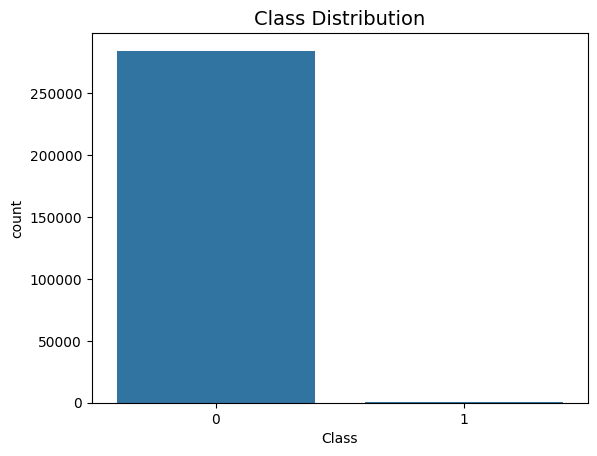

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.countplot(x='Class', data=df.toPandas())
plt.title('Class Distribution', fontsize=14)

In [ ]:
df.select('Time','V1','V2','V3','Amount','Class').show(10)

+----+------------------+-------------------+------------------+------+-----+
|Time|                V1|                 V2|                V3|Amount|Class|
+----+------------------+-------------------+------------------+------+-----+
| 0.0|  -1.3598071336738|-0.0727811733098497|  2.53634673796914|149.62|    0|
| 0.0|  1.19185711131486|   0.26615071205963|  0.16648011335321|  2.69|    0|
| 1.0| -1.35835406159823|  -1.34016307473609|  1.77320934263119|378.66|    0|
| 1.0|-0.966271711572087| -0.185226008082898|  1.79299333957872| 123.5|    0|
| 2.0| -1.15823309349523|  0.877736754848451|    1.548717846511| 69.99|    0|
| 2.0|-0.425965884412454|  0.960523044882985|  1.14110934232219|  3.67|    0|
| 4.0|  1.22965763450793|  0.141003507049326|0.0453707735899449|  4.99|    0|
| 7.0|-0.644269442348146|   1.41796354547385|   1.0743803763556|  40.8|    0|
| 7.0| -0.89428608220282|  0.286157196276544|-0.113192212729871|  93.2|    0|
| 9.0| -0.33826175242575|   1.11959337641566|  1.04436655157316|

<function matplotlib.pyplot.show(close=None, block=None)>

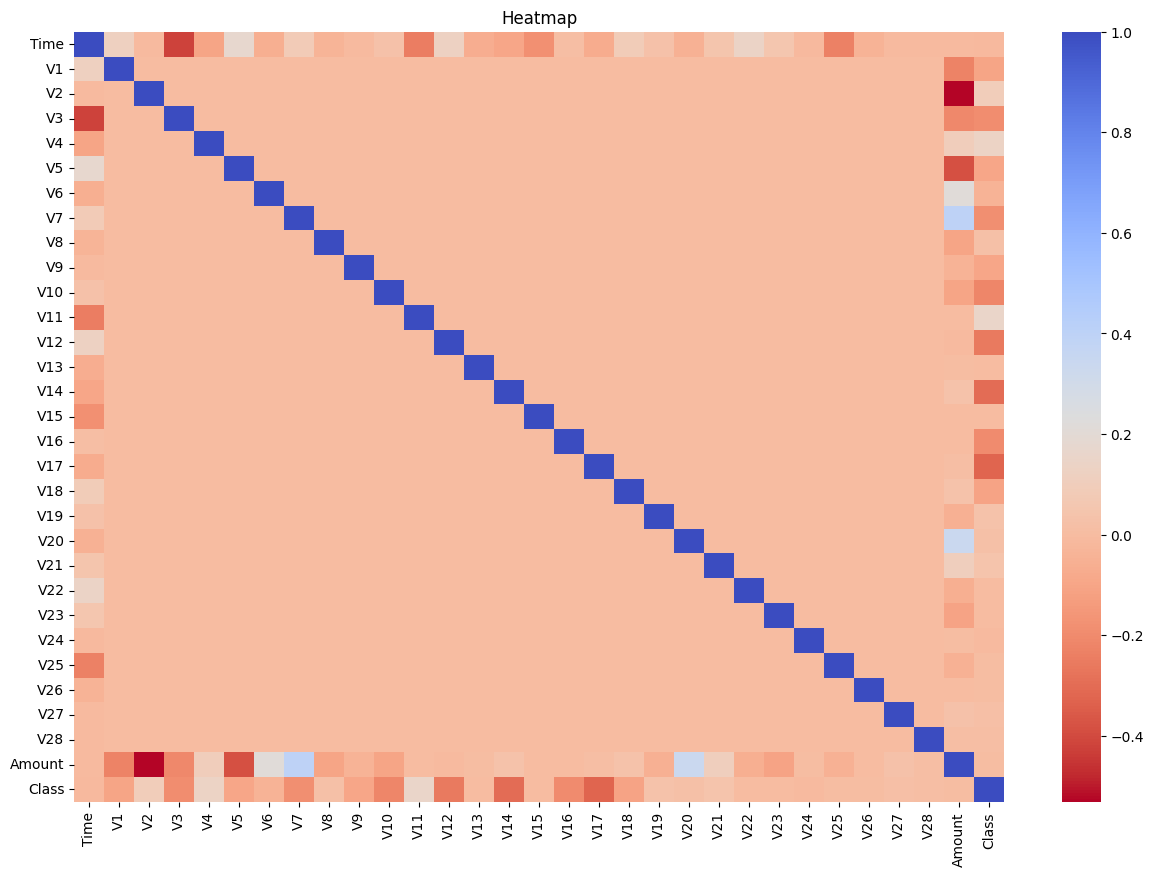

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.toPandas().corr(),cmap='coolwarm_r')
plt.title('Heatmap')
plt.show

Text(0.5, 1.0, 'Not Fraud')

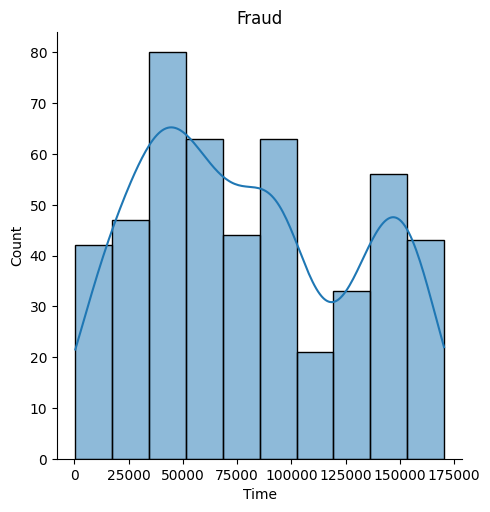

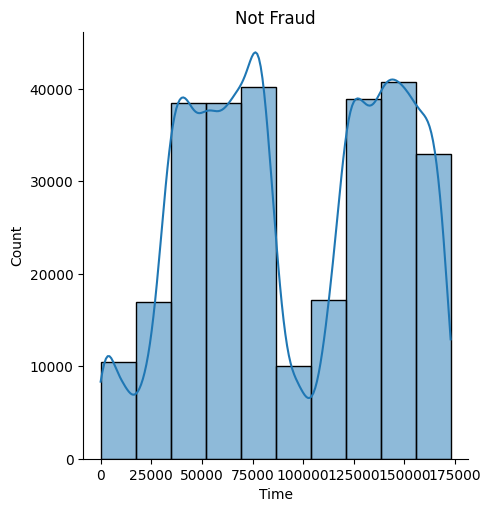

In [ ]:
sns.displot(x='Time',data=df_fraud.toPandas(),kde=True,bins=10)
plt.title('Fraud')

sns.displot(x='Time',data=df_non_fraud.toPandas(),kde=True,bins=10)
plt.title('Not Fraud')

In [ ]:
df_non_fraud=df_non_fraud.sample(df_fraud_count/df_non_fraud_count)

In [ ]:
df_non_fraud_count=df_non_fraud.count()
print('Non-fraud data volume：',df_non_fraud_count)

Non-fraud data volume： 489


In [ ]:
new_df=df_non_fraud.union(df_fraud)

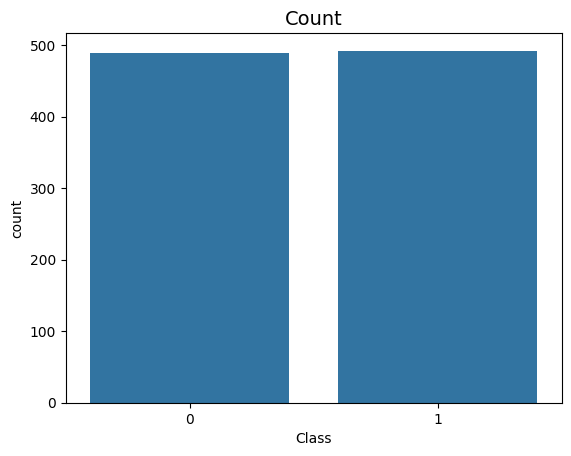

In [ ]:
sns.countplot(x='Class', data=new_df.toPandas())
plt.title('Count', fontsize=14)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

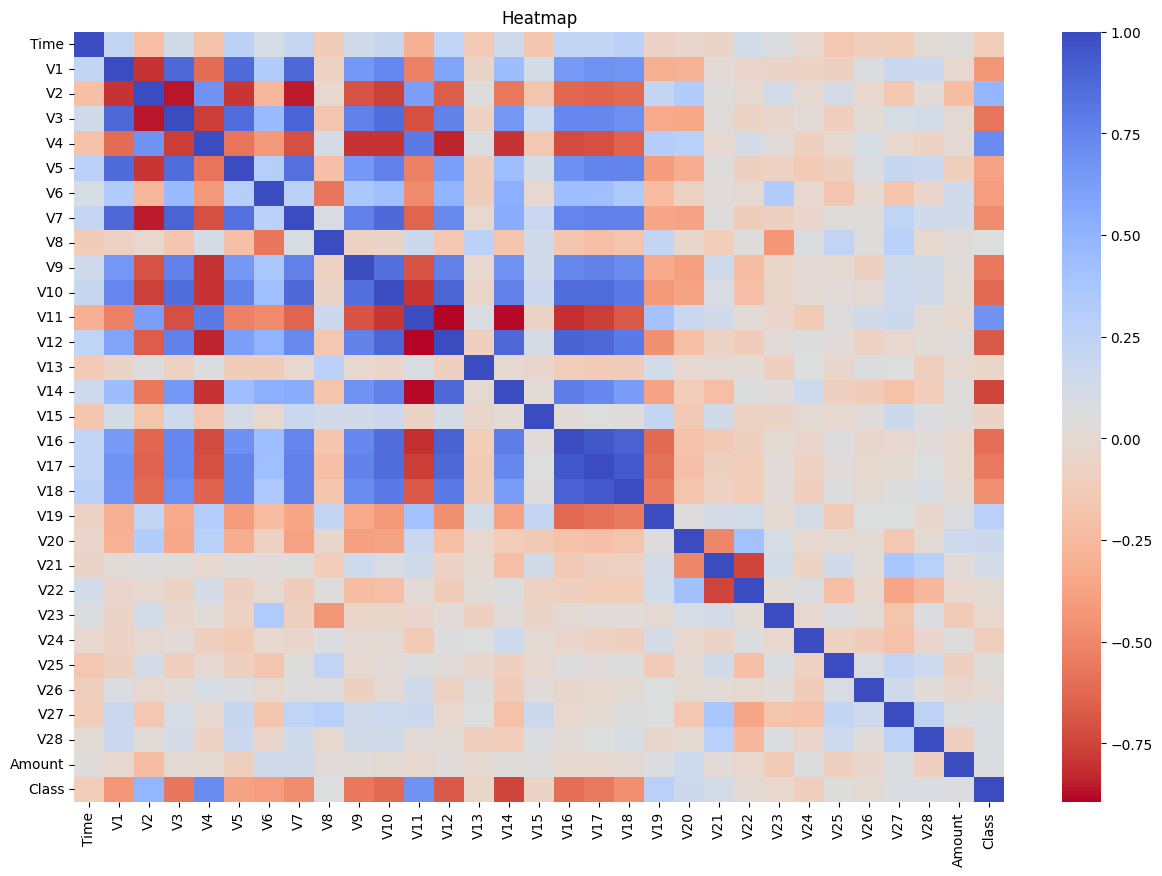

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(new_df.toPandas().corr(),cmap='coolwarm_r')
plt.title('Heatmap')
plt.show

In [ ]:
print('Number of data items in the current data set：',new_df.count())

Number of data items in the current data set： 981


In [ ]:
df_dropDuplicates=new_df.dropDuplicates()

In [ ]:
print('Number of data items after deleting duplicate rows：',df_dropDuplicates.count())

Number of data items after deleting duplicate rows： 962


In [ ]:
df_dropna=df_dropDuplicates.dropna()

In [ ]:
print('Number of data items after deleting rows with missing values：',df_dropna.count())

Number of data items after deleting rows with missing values： 962


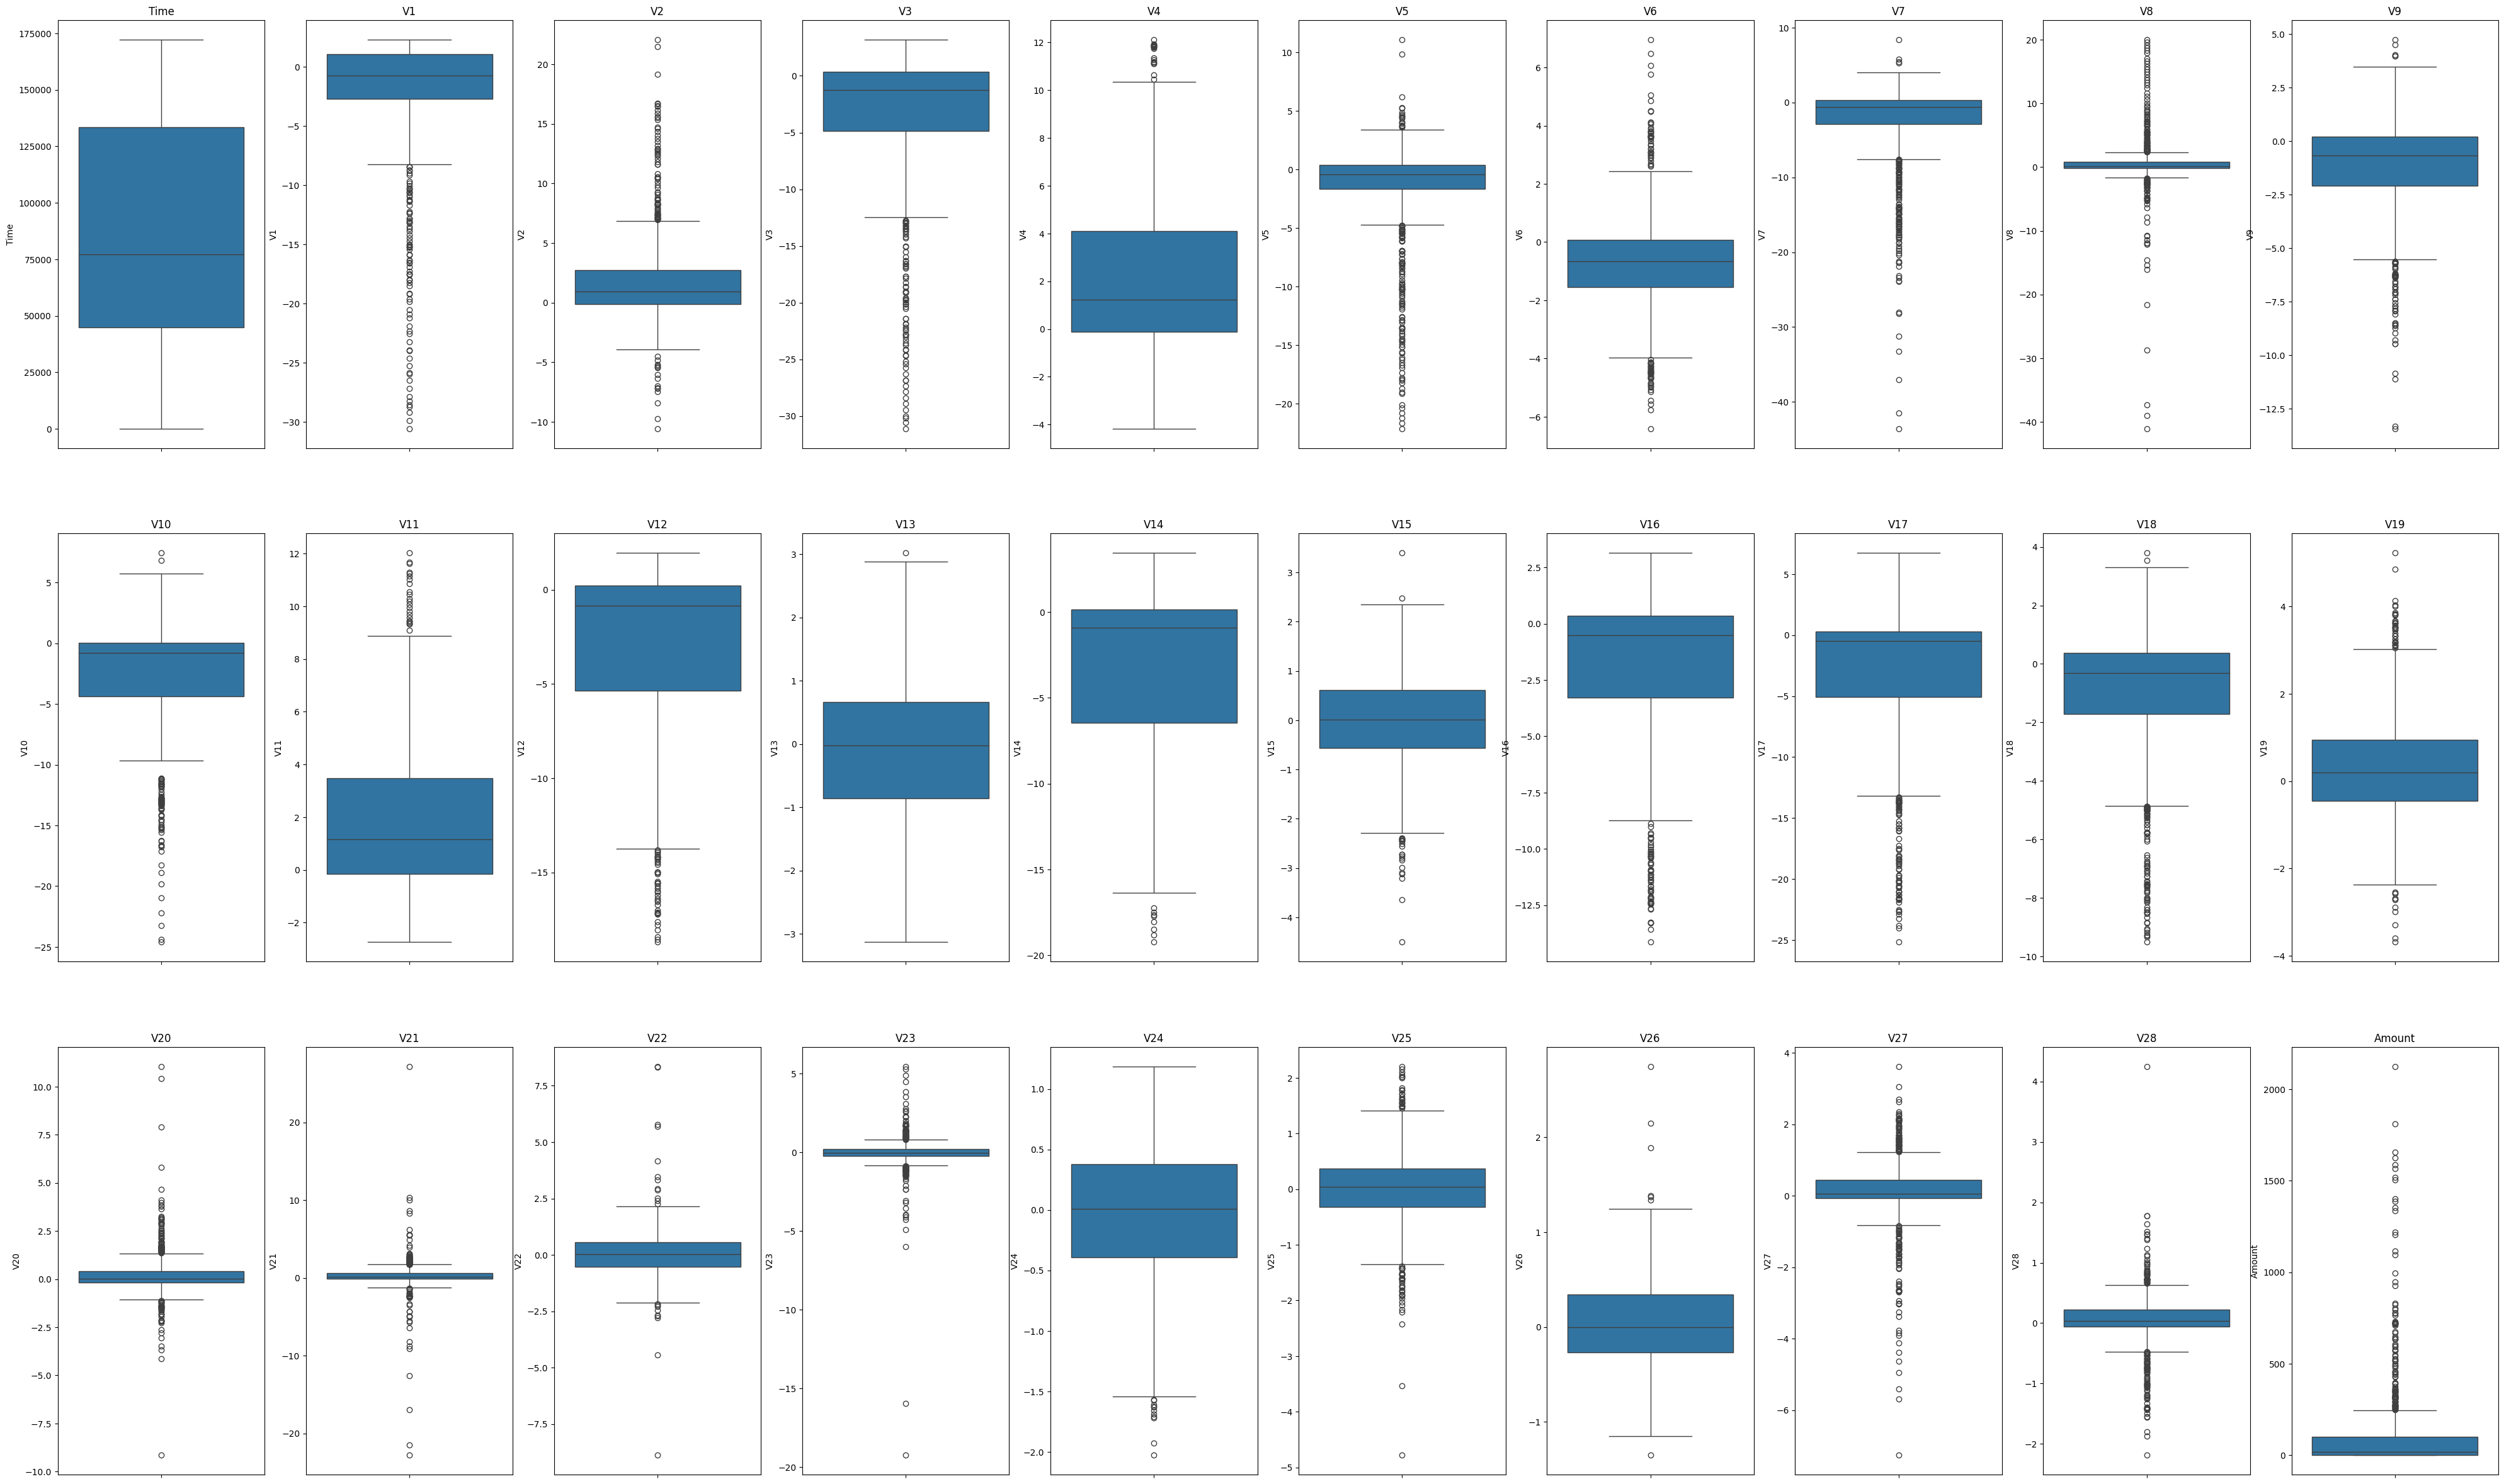

In [ ]:
bounds={}
fig,ax=plt.subplots(3,10, figsize=(50,30))
i=0
for col in feature_columns:
    plt.title(col)
    sns.boxplot( y=col,data=df_dropna.toPandas(),ax=ax[i//10][i%10],whis=1.5)
    ax[i//10][i%10].set_title(col)
    i=i+1
    quantiles = df_dropna.approxQuantile(col,[0.25,0.75],0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5*IQR,quantiles[1] + 1.5*IQR]

plt.show()

In [ ]:
for col in feature_columns:
    df_filtered=df_dropna.filter(df_dropna[col] >= bounds[col][0]).filter(df_dropna[col] <= bounds[col][1])

In [ ]:
print('Number of data items after deleting error values ​​and outliers：',df_filtered.count())


Number of data items after deleting error values ​​and outliers： 833


In [ ]:
assembler=VectorAssembler(inputCols=feature_columns, outputCol="Features")

In [ ]:
df_assembled = assembler.transform(df_filtered)

In [ ]:
df_assembled.select('Time','Features','Class').show(10)

+-------+--------------------+-----+
|   Time|            Features|Class|
+-------+--------------------+-----+
|59097.0|[59097.0,-1.81231...|    0|
|80654.0|[80654.0,1.360015...|    0|
|74696.0|[74696.0,-0.85497...|    0|
|75903.0|[75903.0,1.131657...|    0|
|38349.0|[38349.0,1.476375...|    0|
|40539.0|[40539.0,-2.42975...|    0|
|76063.0|[76063.0,0.945449...|    0|
|59241.0|[59241.0,0.906748...|    0|
|51345.0|[51345.0,-0.85271...|    0|
|81900.0|[81900.0,-1.91214...|    0|
+-------+--------------------+-----+
only showing top 10 rows



In [ ]:
standardScaler = StandardScaler(inputCol="Features", outputCol="Features_scaled")

In [ ]:
df_scaled = standardScaler.fit(df_assembled).transform(df_assembled)

In [ ]:
df_scaled.select("Features", "Features_scaled").show(10)

+--------------------+--------------------+
|            Features|     Features_scaled|
+--------------------+--------------------+
|[59097.0,-1.81231...|[1.21148987325019...|
|[80654.0,1.360015...|[1.65340887417501...|
|[74696.0,-0.85497...|[1.53126973572763...|
|[75903.0,1.131657...|[1.55601326377496...|
|[38349.0,1.476375...|[0.78615539112427...|
|[40539.0,-2.42975...|[0.83105044201379...|
|[76063.0,0.945449...|[1.55929326749292...|
|[59241.0,0.906748...|[1.21444187659635...|
|[51345.0,-0.85271...|[1.05257369311523...|
|[81900.0,-1.91214...|[1.67895190312859...|
+--------------------+--------------------+
only showing top 10 rows



In [ ]:
train_data, test_data = df_scaled.randomSplit([.8,.2])

In [ ]:
lr = LogisticRegression(featuresCol='Features_scaled', labelCol="Class", predictionCol='Prediction',
                               maxIter=10)

In [ ]:
lr_model = lr.fit(train_data)

In [ ]:
predictions = lr_model.transform(test_data)

In [ ]:
result = predictions.select("Class","Prediction")

In [ ]:
result.show()

+-----+----------+
|Class|Prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [ ]:
TP = result.filter(result['Prediction'] == 1).filter(result['Class'] == 1).count()
FN = result.filter(result['Prediction'] == 0).filter(result['Class'] == 1).count()
TN = result.filter(result['Prediction'] == 0).filter(result['Class'] == 0).count()
FP = result.filter(result['Prediction'] == 1).filter(result['Class'] == 0).count()


In [ ]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 =(2*precision*recall)/(precision+recall)
accuracy = (TP+TN)/(TP+TN+FP+FN)

In [ ]:
print("precision:",precision)
print("recall:",recall)
print("F1:",F1)
print("accuracy:",accuracy)

precision: 0.9625
recall: 0.8850574712643678
F1: 0.9221556886227545
accuracy: 0.9277777777777778


In [ ]:
missed=FN/(FN+TN)
print('missed:',missed)

missed: 0.1


(-0.01, 1.0, 0.0, 1.0)

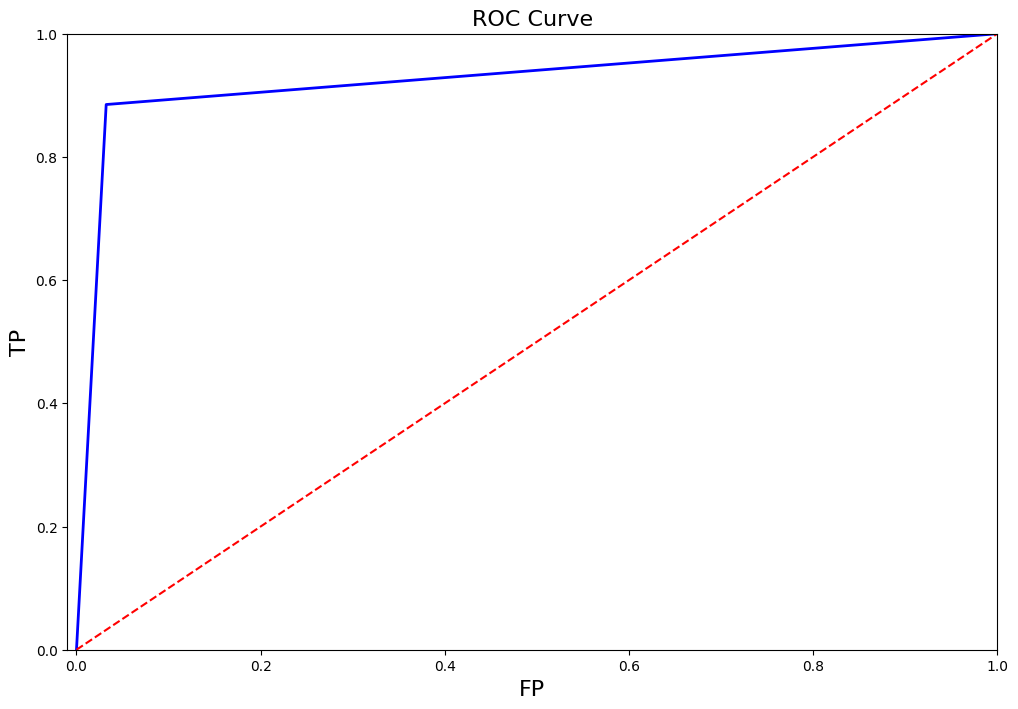

In [ ]:
log_fpr, log_tpr, log_thresold = roc_curve(result.toPandas()['Class'], result.toPandas()['Prediction'])

plt.figure(figsize=(12,8))
plt.title('ROC Curve', fontsize=16)
plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('FP', fontsize=16)
plt.ylabel('TP', fontsize=16)
plt.axis([-0.01,1,0,1])

In [ ]:
export_df = predictions.select('Class', 'Prediction', 'Features')


export_pandas_df = export_df.toPandas()

export_pandas_df.to_csv('fraud_detection_predictions.csv', index=False)

print("CSV file created: fraud_detection_predictions.csv")


CSV file created: fraud_detection_predictions.csv


In [ ]:
from google.colab import files
files.download('fraud_detection_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>